In [4]:
import numpy as np
import astropy.units as u
from astropy.time import Time
from astropy.table import Table
from sbpy.data import Ephem, Phys
from sbpy.activity import (Haser, LTE, NonLTE, photo_timescale, einstein_coeff, 
intensity_conversion, beta_factor, total_number, from_Haser)
import matplotlib.pyplot as plt
import matplotlib
import astropy.constants as con

Calculating Column Density using the NonLTE iterative code `from_pyradex`
=======================================
_____________________________________________________________________________________________

`sbpy.activity` offers an implementation of `pyradex` which is a python wrapper for the NonLTE, iterative fortran code  called RADEX. Radex is described in [van der Tak et al. 2013](https://ui.adsabs.harvard.edu/abs/2007A%26A...468..627V/abstract).

This model takes in an initial guess for the column density and compares the data iteratively against RADEX results, finding the best fit column density for the data. More information about the installation and setup of `pyradex` can be found here [here](https://github.com/keflavich/pyradex), as well as more information about the parameters needed for the [RADEX](https://personal.sron.nl/~vdtak/radex/index.shtml) code. `from_pyradex` returns the best fitting column density based on the data provided which can then be used with the Haser model shown in the previous example. 

RADEX requires information on collider densities in order to determine collision rates. The collider densities are required to be given in the form of a dictionary. For comets, we expect H2O to be our main collisional partner but RADEX does not contain information on collisional rates for H2O. Therefore, the default value for collider densities in sbpy is a scaled version of the H2 collisional rate to account for H2O. This scaling is prominent in a lot of literature, such as [Walker et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...790...96W/abstract), [de Val Borro et al. 2017](https://ui.adsabs.harvard.edu/abs/2018MNRAS.474.1099D/abstract), and [Schoier et al. 2004](https://ui.adsabs.harvard.edu/abs/2005A%26A...432..369S/abstract).

In the case of this module we have chosen to follow the Walker et al. scaling for deriving H2O-H2O collision rates from H2-H2O coefficients. Within this scaling, we apply the square root of the ratio of reduced masses:

$$s = (\frac{m_{H2O}}{m_{H2}})^{0.5}$$          

Where `s` is the scale to multiply the collisional density of H2 against in order to obtain H2O-H2O collision rates.

For the implementation of this code, the user can either define their chosen first guess for column density, or they can calculate it from their data or JPLSpec data `cdensity_Bockelee`. The literature used for this example is the same as in [this notebook](LTE_prodrate_Haser), [Wierzchos et al. 2018](https://ui.adsabs.harvard.edu/abs/2018AJ....156...34W/abstract):

**Important notes:** `pyradex` requires a fortran compiler to be installed in your system. The recommendation is gfortran, which can be installed using [Homebrew](https://brewformulas.org/Gfortran), or any other similar service. 

Warnings of a missing file and RunTime error are normal from pyradex, if the user wants to find out more about them, see the [`pyradex` docs](https://github.com/keflavich/pyradex). The file error comes from the fact that `sbpy` uses, like pyradex, `astroquery.Lamda` for the molecular data files instead of searching them locally (despite the Fortran code still forcing the search for a local molecular data file). In the future, a function will be added to `sbpy` in which a user may build their own molecular data files from JPLSpec information. For now, LAMDA catalog is the primary source of the molecular data file for the implementation of RADEX.


In [5]:
co = Table.read(('data/CO.csv'), format="ascii.csv")
error = np.array([0.2, 0.4, 0.4, 0.4, 0.4]) * 10.**28 # +/- error from literature
Q_error = np.array(co['Q']) + np.array(error) # upper error limit
Q_error = np.log10(np.array(Q_error)) - np.array(co['log(Q)'])
co['Q_error'] = Q_error
print("Table:\n{}\nColumn Names:\n{}".format(co, co.columns))

Table:
     U_T              Time        T_B     Q       log(Q)         Q_error       
------------- ------------------- ---- ------- ----------- --------------------
2017-12-22.21 2017-12-22 05:02:24 0.26 4.4e+28 28.64345268 0.019305151681574984
2017-12-23.09 2017-12-23 02:09:36 0.28 4.6e+28 28.66275783  0.03621217433601842
2017-12-30.14 2017-12-30 03:21:36 0.26 4.6e+28 28.66275783  0.03621217433601842
2017-12-31.13 2017-12-31 03:07:12 0.27 4.6e+28 28.66275783  0.03621217433601842
2018-01-16.03 2018-01-16 00:43:12 0.27 4.6e+28 28.66275783  0.03621217433601842
Column Names:
<TableColumns names=('U_T','Time','T_B','Q','log(Q)','Q_error')>


Model parameters needed, all values are taken directly from the literature.
In this example the molecule identifier will be inputted as a regular expression. 
Regular expressions for mol_tag can be used but the user must be careful not to provide
an ambiguous regular expression. One good thing to remember is that anything between symbols '^' and '\\$'
will be matched exactly, therefore you can avoid an ambiguity error by writing your molecule name as such:
'^name\\$'. A perfect example of this is with the molecule in this example 'CO', simply writing mol_tag = 'CO'
will produce an ambiguity error because it will match CO, CO2, etc. therefore, it is necessary to 
restrict our molecule name regex to '^CO\\$' as presented below.

In [6]:
transition_freq = (230.538 * u.GHz).to('MHz')

aper = 10 * u.m # aperture

mol_tag = '^CO$' # regex molecule identifier

temp_estimate = 25. * u.K 

vgas = 0.5 * u.km / u.s

target = 'C/2016 R2'

b = 0.74 # intrinsic antenna value

Obtaining molecular data from the JPL Molecular Spectroscopy Catalog using `sbpy.data.phys`. 
See documentation for a detailed breakdown of the resulting object and the values stored in the object.

In [7]:
mol_data = Phys.from_jplspec(temp_estimate, transition_freq, mol_tag) # molecular data from JPLSpec

intl = intensity_conversion(mol_data) # calculate line intensity

mol_data.apply([intl.value] * intl.unit,
                    name='Integrated line intensity at desired temp') # store value

Obtaining the Einstein Coefficient. In this example, we will obtain our Einstein Coefficient from
LAMDA catalog and append it to our molecular data Phys object. In [this notebook](LTE_prodrate_without_photolysis.ipynb) we have been calculating it through sbpy/JPLSpec. It is possible that your transition frequency values may not exactly match the LAMDA catalog to the 4th significant figure, especially if you're using JPLSpec. Therefore, we recommend when using this method
that you match your transition frequency with the LAMDA value over the JPLSpec value, since `from_jplspec` is
designed to pick the closest transition frequency within a range of 1 GHz, whereas LAMDA will expect the
exact value found in their catalog.

In [8]:
from astroquery.lamda import Lamda

mol_name = 'CO' # LAMDA molecule name

lam_search = Lamda.query(mol=mol_name.lower()) # LAMDA Query

lam_result = lam_search[1] # outputs CO table

lam_found = lam_result[lam_result['Frequency'] == transition_freq.to('GHz').value] # parse results at frequency

au_cat = lam_found['EinsteinA'] # get Einstein Coefficient

au_cat = au_cat.data[0] # get value of coefficient

au = au_cat / u.s # define the unit

mol_data.apply([au.value] * au.unit, name='eincoeff') # store einstein coefficient

/Users/gianni0603/anaconda/lib/python3.6/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


Initialize the `sbpy.activity.Haser` model in order to perform our production rate calculations. 
`Q_estimate` first guess for the production rate was obtained running `from_Drahus` for the same data set before doing this example

In [9]:
Q_estimate = 3.594*10**(28) / u.s 

parent = photo_timescale('CO') * vgas # parent photodissociation rate

coma = Haser(Q_estimate, vgas, parent) # initializing the model with an estimate 

Run the `from_pyradex` iterative code on the data to find best fit column densities, and then calculate total number based on telescope geometry. Use Haser model for the calculation of production rates.

You can give a column density first guess either using `sbpy.data.LTE` `cdensity_Bockelee` function, or user-defined into the data class. In this example, we'll use `cdensity_Bockelee`

Since our data file contains 6 different data points of observation times and integrated flux, we can
calculate production rates for all of these 6 data points using a python for loop.

**IMPORTANT: Because we are using a for loop, and some of the values that should be appended to the `mol_data`
phys object are calculated within the loop itself, we must initialize our columns within the phys object
BEFORE performing the loop. This is because you cannot iteratively redefine the same column of data within a 
phys object, but you CAN change the value of an already defined column as many times as you want.
Since our `beta`, `cdensity` and `total_number` values vary with every iteration,
and since our production rate needs these values within the loop, we must simply change the value of our
already defined columns for beta, column density, and total number everytime we iterate. Keep in mind when you initialize the column you must initialize it with the correct units and correct type (float, int, str). If you get an error saying there are duplicate columns, it is most likely due to what has been mentioned in this note, and you will have to reinitialize your mol_data object before trying to enter more data in**

In [10]:
nonlte = NonLTE()
q_found_pyradex = []
lte = LTE()

for i in range(0, 5):

    time = Time(co['Time'][i], format='iso')
    integrated_flux = co['T_B'][i] * u.K * u.km / u.s
    ephemobj = Ephem.from_horizons(target, epochs=time.jd)
    beta = beta_factor(mol_data, ephemobj)
    mol_data['beta'] = beta
    cdensity_bockelee = lte.cdensity_Bockelee(integrated_flux, mol_data) # col density first guess
    mol_data['cdensity'] = cdensity_bockelee
    cdensity = nonlte.from_pyradex(integrated_flux, mol_data)
    mol_data['cdensity'] = cdensity
    tnum = total_number(mol_data, aper, b) # total number of molecules in aperture
    mol_data['total_number'] = tnum

    Q = from_Haser(coma, mol_data, aper=aper) # production rate from Haser model

    q_found_pyradex.append(np.log10(Q.value)[0])

q_pred_co = list(co['log(Q)'])

/Users/gianni0603/anaconda/lib/python3.6/site-packages/pyradex/core.py:529: UserWarning: Using a default ortho-to-para ratio (which will only affect species for which independent ortho & para collision rates are given)
  warnings.warn("Using a default ortho-to-para ratio (which "
/Users/gianni0603/anaconda/lib/python3.6/site-packages/pyradex/core.py:910: RuntimeWarning: invalid value encountered in true_divide
  frac_level_diff = level_diff/self.level_population
/Users/gianni0603/anaconda/lib/python3.6/site-packages/pyradex/core.py:998: RuntimeWarning: overflow encountered in exp
  bnutex = thc*xt/(np.exp(earg)-1.0)


Closest Integrated Flux:[0.25920121] K km / s
Given Integrated Flux: 0.26 K km / s
[2.17657296e+14] 1 / cm2


Closest Integrated Flux:[0.27889648] K km / s
Given Integrated Flux: 0.28 K km / s
[2.34400165e+14] 1 / cm2


Closest Integrated Flux:[0.25920121] K km / s
Given Integrated Flux: 0.26 K km / s
[2.17657296e+14] 1 / cm2


Closest Integrated Flux:[0.26905909] K km / s
Given Integrated Flux: 0.27 K km / s
[2.26028731e+14] 1 / cm2


Closest Integrated Flux:[0.26905909] K km / s
Given Integrated Flux: 0.27 K km / s
[2.26028731e+14] 1 / cm2


In [11]:
print("The Resulting Production Rates for CO in {} using Haser model are:\n {}".format(target, np.round(q_found_pyradex,3)))
print("Residuals:\n{}".format(np.round((np.array(q_pred_co)) - (np.array(q_found_pyradex)),3)))
print("Literature errors:\n{}".format(np.round(co['Q_error'],3)))

The Resulting Production Rates for CO in C/2016 R2 using Haser model are:
 [28.727 28.758 28.716 28.731 28.709]
Residuals:
[-0.084 -0.096 -0.053 -0.068 -0.047]
Literature errors:
[0.019 0.036 0.036 0.036 0.036]


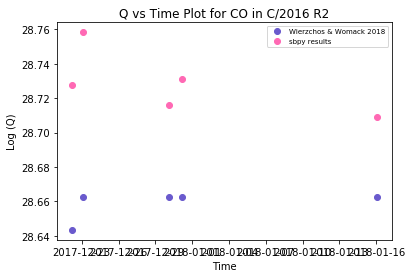

In [13]:
time_co = list(co['Time'])
time_co = matplotlib.dates.datestr2num(time_co)

plt.plot_date(time_co, q_pred_co, 'o', color='slateblue', label='Wierzchos & Womack 2018')
plt.plot_date(time_co, q_found_pyradex, 'o', color='hotpink', label='sbpy results')
plt.xlabel('Time')
plt.ylabel('Log (Q)')
plt.legend(loc='best', fontsize='x-small')
plt.title('Q vs Time Plot for CO in {}'.format(target))
plt.show()

It is clear that the implementation of pyradex gives better results than the example in [this notebook](LTE_prodrate_Haser.ipynb) in comparison to the literature, and it is done entirely within `sbpy` functionalities, offering the user a rigorous way to calculate column densities, and from those, production rates using the Haser model within `sbpy`. 

Even so, `sbpy` allows for flexibility in terms of data entry. Hardly traceable inconsistencies like are common in cometary studies, since a lot depends on the molecular catalogs that the data is obtained from, or what calculations are used. This is exactly why sbpy offers flexibility in all its functions through the use of `sbpy.data` classes, which allow the user to define their preferrred parameters if they do not happen to be satisfied with the catalog functionalities and derivations of parameters that sbpy offers. Yet we recommend the use of as many sbpy functionalities as possible in order to maintain consistency in your calculations, which may prove to be important when conversations about comet classification arise. 

Helpful Links
=======
___________________________________________

Relevant Notebooks
-----------------
- [How to calculate LTE production rates without photolysis effects](LTE_prodrate_without_photolysis.ipynb)
- [How to calculate LTE production rates with Haser model](LTE_prodrate_Haser.ipynb)
- [How to use Phys data class and `from_jplspec`](../data/Phys.ipynb)
- [What is `astroquery.jplspec`](../data/jplspec.ipynb)

Relevant Links
-------------
- [LAMDA Queries with astroquery](https://astroquery.readthedocs.io/en/latest/lamda/lamda.html)
- [JPLSpec Queries with astroquery](https://astroquery.readthedocs.io/en/latest/jplspec/jplspec.html)
- [sbpy Activity Haser Class](https://sbpy.readthedocs.io/en/latest/api/sbpy.activity.Haser.html#sbpy.activity.Haser)
- [sbpy Ephem data class](https://sbpy.readthedocs.io/en/latest/sbpy/data/index.html#how-to-use-ephem)
- [sbpy Phys data class](https://sbpy.readthedocs.io/en/latest/sbpy/data/index.html#how-to-use-phys)
- [sbpy data class alternative field names](https://sbpy.readthedocs.io/en/latest/sbpy/data/fieldnames.html#list-of-alternative-field-names)
- [pyradex source code](https://github.com/keflavich/pyradex)
- [RADEX fortran source code](https://personal.sron.nl/~vdtak/radex/)
- [RADEX homepage](https://personal.sron.nl/~vdtak/radex/index.shtml)
- [sbpy citation (please cite our work)](http://joss.theoj.org/papers/10.21105/joss.01426)